<a href="https://colab.research.google.com/github/WxAnalyst/Colab-Projects/blob/main/Temperature_Streaks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ACIS Cold and Warm 'Streaks'
This notebook is designed to download data from xmacis and output the length of cold and warm streaks (where the average daily temperature is below or above climatological normals). The output will also calculate the number of colder and warmer than normal days in the specified period.

In [ ]:
!pip install siphon
from siphon.simplewebservice.acis import acis_request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

cwa = "PIH" #@param {type:"string"}
start_date = '2023-01-01' #@param {type:"date"}
end_date = '2023-04-25'   #@param {type:"date"}
params = {"cwa": cwa, #"PIH",
          "elems":
            [{"name": "avgt",
              "normal": "departure"}],
          "sdate": start_date, #"2023-01-01"},
          "edate": end_date,   #"2023-03-31",
          "meta": "name,elems"}

ds = acis_request("MultiStnData", params)

In [5]:
# Create and cleanup the dataframe
dj = pd.DataFrame(ds['data'])
dj['meta'] = dj['meta'].apply(lambda x: x['name'])
for i in range(0, len(dj.data)):
   dj.data[i] = [item for sublist in dj.data[i] for item in sublist]

# Gather the longest streaks of warmer than and colder than normal temperatures
cold_streak = []
warm_streak = []
countCold = []
countWarm = []
# Iterate through all stations
for ser in range(0, len(dj['data'])):
  cold = 0
  warm = 0
  count_cold = 0
  count_warm = 0
  max_cold = 0
  max_warm = 0
  # Iterate through values
  for i in range(0, len(dj['data'][ser])):
    if dj.data[ser][i] == 'M':
      continue
    if float(dj.data[ser][i]) < 0:
      cold += 1
      if warm > max_warm:
        max_warm = warm
      warm = 0
      count_cold += 1
    if float(dj.data[ser][i]) > 0:
      warm += 1
      if cold > max_cold:
        max_cold = cold
      cold = 0
      count_warm += 1
    if float(dj.data[ser][i]) == 0:
      if warm > max_warm:
        max_warm = warm
      warm = 0
      if cold > max_cold:
        max_cold = cold
      cold = 0
  cold_streak.append(max_cold)
  warm_streak.append(max_warm)
  countCold.append(count_cold)
  countWarm.append(count_warm)

# Add the streaks and the counts to the dataframe
dj['cold_streak'] = cold_streak
dj['warm_streak'] = warm_streak
dj['count_cold'] = countCold
dj['count_warm'] = countWarm

def replace_m_with_nan(lst):
  # Set missing 'M' values to nan
  return [np.nan if x == 'M' else x for x in lst]

dj.data = dj.data.apply(replace_m_with_nan)
table = dj[['meta', 'cold_streak','warm_streak','count_cold','count_warm']].copy()

site_list = dj.sort_values('meta')
picker = widgets.Dropdown(options = site_list.meta, value = "POCATELLO REGIONAL AIRPORT")
picker

Dropdown(index=85, options=('3 MILE IDAHO', 'ABERDEEN EXPERIMENT STN', 'AMERICAN FALLS', 'AMERICAN FALLS 6 NE'…

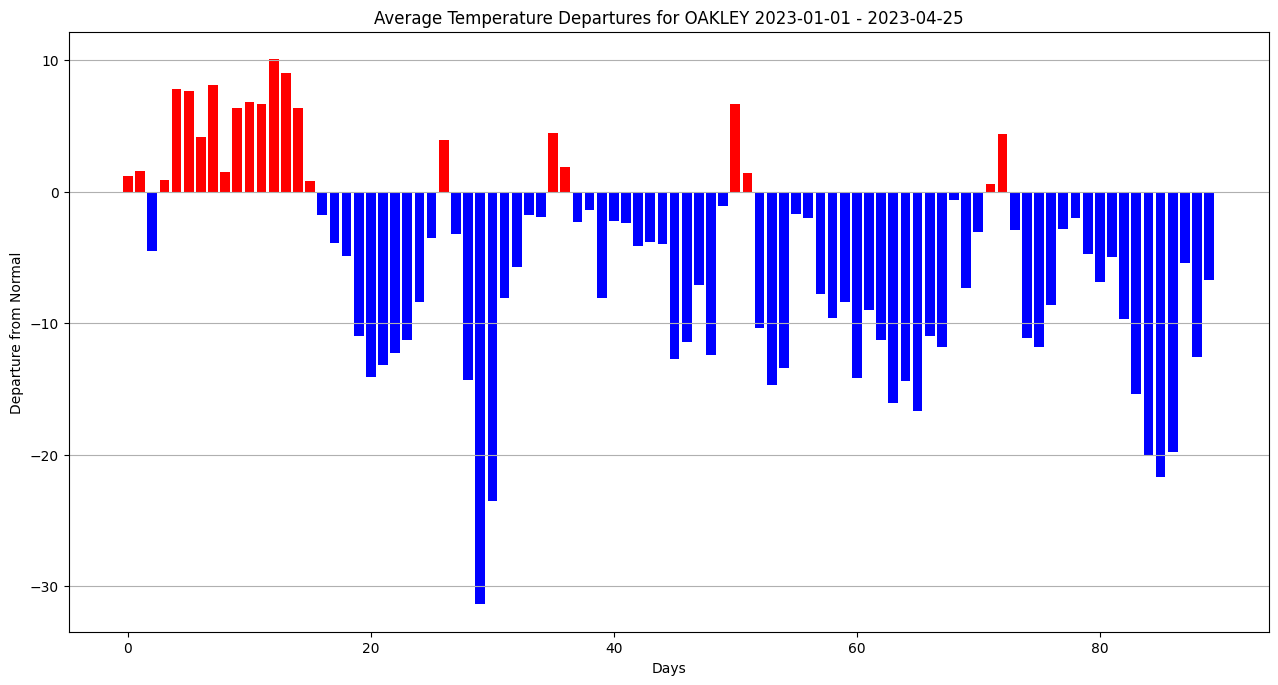

In [31]:
data_list = list(site_list.query('meta == @picker.value')['data'] )

fig = plt.figure(figsize = (12,6))
ax = fig.add_axes([-20,20,1,1])
data = [float(x) for x in data_list[0]]
x_axis = range(0, len(data))
y_axis = data
colors = ['r' if d >= 0 else 'blue' for d in data]


ax.bar(x_axis, y_axis, color = colors)
ax.set_title("Average Temperature Departures for " + picker.value + " "+ start_date + " - " + end_date)
ax.set_ylabel('Departure from Normal')
ax.set_xlabel("Days")
ax.grid(axis = 'y')
fig.show()